<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evolution-of-Basketball" data-toc-modified-id="Evolution-of-Basketball-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evolution of Basketball</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Bringing-in-2020-2021-Season-Game-Data-from-NBA-API" data-toc-modified-id="Bringing-in-2020-2021-Season-Game-Data-from-NBA-API-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Bringing in 2020-2021 Season Game Data from NBA API</a></span></li></ul></li></ul></li></ul></div>

# Evolution of Basketball

## Problem Statement:

The game of basketball in the NBA has changed drastically from when players mostly stuck to their roles to a game where traditional positions are much more fluid. I will cluster / classify players into new roles in order to update the traditional basketball positions based on their new roles.

In [244]:
#pip install nba-api
#!pip install nbashots

  Created wheel for nbashots: filename=nbashots-0.1.0a9-py3-none-any.whl size=10908 sha256=62f5c8d3a72d78a583320c11eda96f3fc6ed40449552486724ace95451c1ad9e
  Stored in directory: c:\users\kendr\appdata\local\pip\cache\wheels\10\42\06\5db764be5802a3863f502b92b77fb3f4f1f7ecfaeebbf58f8e
  Created wheel for seaborn: filename=seaborn-0.6.0-py3-none-any.whl size=151750 sha256=ddf6d9a120e558189107b0bfbe37cfd88596432890da8f5030fe1195138b411f
  Stored in directory: c:\users\kendr\appdata\local\pip\cache\wheels\de\7a\8d\e20b3dd53fa827f9f1ff1c3f1c69b957c24d7d1f69b587244a
Successfully built nbashots seaborn
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0


### Imports

In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import seaborn as sns


## Background Info

I picked a player that has played in both a more traditional role several years ago and has expanded / evolved his style of play with the current way basketball is played at the NBA level.



In [239]:
#https://github.com/danchyy/Basketball_Analytics/blob/master/Scripts/2018_19_season/brook_lopez_evolution/brook_lopez.ipynb
#https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.static.players import find_players_by_full_name

lopez_id = find_players_by_full_name("Brook Lopez")[0]['id']


In [240]:
lopez_id

201572

In [241]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

### Bringing in 2020-2021 Season Game Data from NBA API

https://github.com/swar/nba_api

In [3]:
df_p = pd.read_csv('../data/play_by_play.csv')

In [19]:
df_p.columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

In [22]:
df_p.head(15)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,22000482,2,12,0,1,7:42 PM,12:00,NaN,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0
1,22000482,4,10,0,1,7:42 PM,12:00,Jump Ball Jordan vs. Bagley III: Tip to Brown,NaN,NaN,...,Kings,SAC,4,1628971,Bruce Brown,1.610613e+09,Brooklyn,Nets,BKN,1
2,22000482,7,1,79,1,7:42 PM,11:39,Irving 14' Pullup Jump Shot (2 PTS),NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
3,22000482,8,2,79,1,7:42 PM,11:25,NaN,NaN,MISS Fox 11' Pullup Jump Shot,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
4,22000482,9,4,0,1,7:42 PM,11:22,Jordan REBOUND (Off:0 Def:1),NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
5,22000482,10,1,1,1,7:42 PM,11:16,Irving 27' 3PT Jump Shot (5 PTS) (Harden 1 AST),NaN,NaN,...,Nets,BKN,0,0,NaN,NaN,NaN,NaN,NaN,1
6,22000482,12,2,1,1,7:43 PM,10:57,NaN,NaN,MISS Bagley III 3PT Jump Shot,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
7,22000482,13,4,0,1,7:43 PM,10:55,Harden REBOUND (Off:0 Def:1),NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
8,22000482,14,2,1,1,7:43 PM,10:36,MISS Harden 26' 3PT Jump Shot,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1
9,22000482,15,4,0,1,7:43 PM,10:29,NaN,NaN,Holmes REBOUND (Off:0 Def:1),...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1


In [32]:
kings_nets = (df_p[['PCTIMESTRING', 'PERIOD', 'SCORE', 'SCOREMARGIN', 'PLAYER1_TEAM_ABBREVIATION']][(df_p['GAME_ID'] == 22000482)].dropna())

In [95]:
kings_nets.tail()

,PCTIMESTRING,PERIOD,SCORE,SCOREMARGIN,PLAYER1_TEAM_ABBREVIATION
6751,1:22,4,113 - 125,12,BKN
6755,1:01,4,113 - 126,13,BKN
6756,1:01,4,113 - 127,14,BKN
6757,0:49,4,115 - 127,12,SAC
6760,0:16,4,118 - 127,9,SAC


In [93]:
kings_nets['PCTIMESTRING']

2       11:39
5       11:16
10      10:24
11      10:07
15       9:31
        ...  
6751     1:22
6755     1:01
6756     1:01
6757     0:49
6760     0:16
Name: PCTIMESTRING, Length: 248, dtype: object

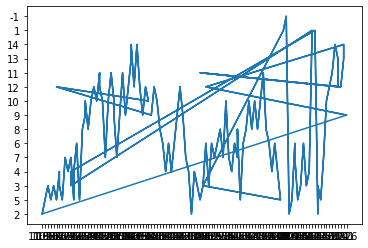

In [33]:
plt.plot (kings_nets['PCTIMESTRING'],kings_nets['SCOREMARGIN'])

In [96]:
df_t = pd.read_csv('../data/player_tracking.csv')

In [97]:
df_t.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,SPD,...,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,FG_PCT,DFGM,DFGA,DFG_PCT
0,22000482,1610612758,SAC,Sacramento,203084,Harrison Barnes,F,NaN,36:42,0.0,...,0,0,0.0,0,0,0.0,0.636,0,0,0.0
1,22000482,1610612758,SAC,Sacramento,1628963,Marvin Bagley III,F,NaN,30:13,0.0,...,0,0,0.0,0,0,0.0,0.500,0,0,0.0
2,22000482,1610612758,SAC,Sacramento,1626158,Richaun Holmes,C,NaN,26:17,0.0,...,0,0,0.0,0,0,0.0,0.750,0,0,0.0
3,22000482,1610612758,SAC,Sacramento,1627741,Buddy Hield,G,NaN,36:34,0.0,...,0,0,0.0,0,0,0.0,0.333,0,0,0.0
4,22000482,1610612758,SAC,Sacramento,1628368,De'Aaron Fox,G,NaN,38:29,0.0,...,0,0,0.0,0,0,0.0,0.500,0,0,0.0


In [98]:
df_t.isna().sum()

GAME_ID                  0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_CITY                0
PLAYER_ID                0
PLAYER_NAME              0
START_POSITION       15292
COMMENT              19678
MIN                      0
SPD                      0
DIST                     0
ORBC                     0
DRBC                     0
RBC                      0
TCHS                     0
SAST                     0
FTAST                    0
PASS                     0
AST                      0
CFGM                     0
CFGA                     0
CFG_PCT                  0
UFGM                     0
UFGA                     0
UFG_PCT                  0
FG_PCT                   0
DFGM                     0
DFGA                     0
DFG_PCT                  0
dtype: int64

In [108]:
df_t.dtypes

GAME_ID                int64
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_CITY             object
PLAYER_ID              int64
PLAYER_NAME           object
START_POSITION        object
COMMENT               object
MIN                   object
SPD                  float64
DIST                 float64
ORBC                   int64
DRBC                   int64
RBC                    int64
TCHS                   int64
SAST                   int64
FTAST                  int64
PASS                   int64
AST                    int64
CFGM                   int64
CFGA                   int64
CFG_PCT              float64
UFGM                   int64
UFGA                   int64
UFG_PCT              float64
FG_PCT               float64
DFGM                   int64
DFGA                   int64
DFG_PCT              float64
dtype: object

In [153]:
xcols=['SPD', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 'AST', 'CFGA', 'CFG_PCT', 'UFGA', 'UFG_PCT', 'DFGA', 'DFG_PCT']

In [139]:
X = df_t[['PLAYER_NAME','SPD', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 'AST', 'CFGA', 'CFG_PCT', 'UFGA', 'UFG_PCT', 'DFGA', 'DFG_PCT']]

In [140]:
X = X[X['SPD'] != 0]

In [188]:
X = X.groupby('PLAYER_NAME')['SPD', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 'AST', 'CFG_PCT', 'UFG_PCT', 'DFG_PCT'].mean()

<ipython-input-188-4dbab589c4f6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  X = X.groupby('PLAYER_NAME')['SPD', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 'AST', 'CFG_PCT', 'UFG_PCT', 'DFG_PCT'].mean()


In [189]:
ss = StandardScaler()

In [224]:
Xs = ss.fit_transform(X)
dbs = DBSCAN(eps=1, min_samples=3)

In [225]:
dbs.fit(Xs)

DBSCAN(eps=1, min_samples=3)

In [226]:
X['cluster'] = dbs.labels_

In [227]:
silhouette_score(X, dbs.labels_)

-0.41982615021112507

In [228]:
df_t['cluster'].unique()

array([ 0, -1,  1,  2,  3,  4, 47, 40,  5,  6, 16,  7, 72, 22, 60,  8, 32,
        9, 23, 10, 11, 43, 12, 13, 58, 14, 15, 24, 63, 18, 17, 73, 19, 31,
       20, 21, 25, 26, 27, 28, 29, 48, 30, 42, 54, 77, 38, 34, 37, 67, 33,
       35, 36, 59, 51, 68, 70, 39, 41, 69, 46, 44, 45, 55, 65, 56, 74, 49,
       57, 50, 52, 61, 53, 71, 75, 62, 66, 76, 64], dtype=int64)

In [233]:
X['cluster'].value_counts(normalize=True)

-1     0.613169
 1     0.228395
 2     0.026749
 6     0.014403
 13    0.012346
 7     0.010288
 4     0.010288
 9     0.008230
 0     0.008230
 3     0.006173
 5     0.006173
 17    0.006173
 16    0.006173
 18    0.006173
 10    0.006173
 11    0.006173
 12    0.006173
 14    0.006173
 15    0.006173
 8     0.006173
Name: cluster, dtype: float64

In [231]:
X.groupby('PLAYER_NAME')['cluster'].value_counts()

PLAYER_NAME      cluster
Aaron Gordon     -1         1
Aaron Holiday    -1         1
Aaron Nesmith    -1         1
Abdel Nader      -1         1
Adam Mokoka       0         1
                           ..
Yogi Ferrell     -1         1
Yuta Watanabe    -1         1
Zach LaVine      -1         1
Zeke Nnaji        11        1
Zion Williamson  -1         1
Name: cluster, Length: 486, dtype: int64

<AxesSubplot:xlabel='PLAYER_NAME', ylabel='cluster'>

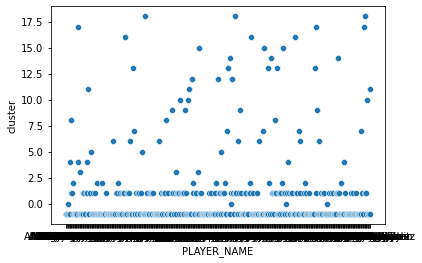

In [238]:
sns.scatterplot(data=X, x = X.index, y = X['cluster'])